In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

/Users/florianmuellerklein/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/florianmuellerklein/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Convolutional Neural Networks and TensorBoard

This will be the same notebook as the FashionMNIST ConvNets example, except that we will be logging with TensorBoard.

In [2]:
class_dict = {0: 't-shirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'ankle boot'}

(48000, 28, 28, 1) (48000, 10) (12000, 28, 28, 1) (12000, 10)


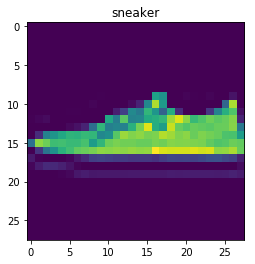

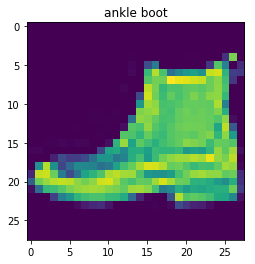

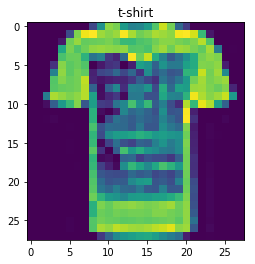

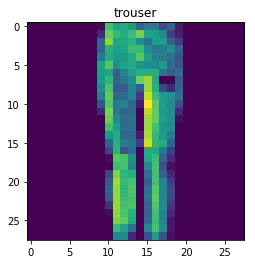

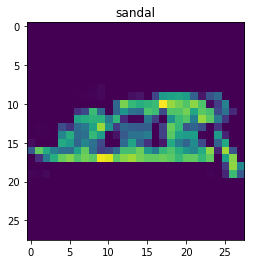

In [3]:
lblr = LabelBinarizer()

data_train = pd.read_csv('Fashion_MNIST/fashion-mnist_train.zip', compression='zip')
data_test = pd.read_csv('Fashion_MNIST/fashion-mnist_test.zip', compression='zip')

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

# get the training data from the csv
X = np.array(data_train.iloc[:, 1:])
y = lblr.fit_transform(np.array(data_train.iloc[:, 0]))

# split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

# get the test data from the csv
X_test = np.array(data_test.iloc[:, 1:])
y_test = lblr.transform(np.array(data_test.iloc[:, 0]))

# reshape the data so the images are 2d matrices
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

# make sure the images are all float32 and with values between 0 and 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_test /= 255
X_val /= 255

# check the shapes
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# display some of the images with the class as title, make sure we loaded things correctly
for i in range(5):
    plt.title(class_dict[lblr.inverse_transform(y_train[i].reshape(1,10))[0]])
    plt.imshow(X_train[i].squeeze())
    plt.show()

Again, we will need placeholders for our batches when we use minibatch gradient descent.

In [4]:
with tf.name_scope('input_placeholder'):
    X = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='X')
    
with tf.name_scope('targets_placeholder'):
    y = tf.placeholder(tf.float32, shape=(None, 10), name='y')

Set up our NN hyperparameters

In [5]:
LR = 0.001
EPOCHS = 15
BATCHSIZE = 32

Much like our vanailly neural network example, we will create generic layer functions that take certain values as parameters. These functions will allow us to quickly and easily set up our Convolutional neural network with little redudancy. They will also allow us to rapidly prototype different architectures, if we wanted more or less layers in any region of the network


### Convolutional Layers

The operation that the kernels perform in a convolutional neural network is a bit different than the typical matrix multiplies that we've worked with previously. Luckily, TensorFlow has a built in convolution operation, `tf.nn.conv2d`, within the `nn` module. After setting up our weights and our input data we can just use that `conv2d` operation in place of the `matmul` operation that we used previously. The weight matrix for our convoutional layers will have shape `[kernel_height, kernel_width, in_channels, out_channels]`. The kernel size parameters are self explainatory. We have to define `in_channels` because the kernels will act on each channel of the incoming data, for an image with 3 channels (RGB) the kernel will act on each of the channels concurrently. In other words, the kernel is as 'deep' as the number of channels in the tensor that it's acting on.  The `out_channels` parameter will take care of how many kernels we have in our specific layer. If we set our convolution layer to have 16 kernels then this parameter will be set to 16, and we will end up with 16 features maps after this operation.

### Pooling Layers

The pooling operation provided in the `tf.nn` module is mostly straight forward. The `tf.nn.max_pool` function simply takes some input and does the max pool operation with the desired window size and strides. However, the window size and strides parameters take four values and we typically only talk about two values for each. For the window we think about the height and the width, and for the strides we think about the jumping distance on two axis. This is because the data that flows through these CNNs exists as 4d tensors so we need to account for each dimension in the operations. So it's customary to set the pooling size in this way, `[1, window_height, window_width, 1]`, with the ones representing the batch and channels dimensions of the image tensor (we dont' want to pool over those dimensions). The strides will be similarly defined `[1, travel_distance_x, travel_distance_y, 1]`. 

In [6]:
def conv_layer(X, in_dims, n_kernels, kernel_size, name, activation=None):
    '''
    Sets up a convolutional layer to be used to build a CNN. 
    
    Parameters:
    X: input data for the layer
    in_dims: number of channels incoming to this layer
    n_kernels: number of convolutional kernels to use in the layer
    kernel_size: the size of each kernel as (kernel_size, kernel_size)
    name: the name of the scope to be used with this layer
    activation: the tensorflow nonlinearity to be used for each neuron
    
    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        init = tf.truncated_normal([kernel_size, kernel_size, in_dims, n_kernels], stddev=0.1)
        W = tf.Variable(init, name='kernel_weights_{}'.format(name))
        b = tf.Variable(tf.constant(0.1, shape=[n_kernels]))
        conv = tf.nn.conv2d(X, W, strides=[1,1,1,1], padding='SAME') + b
        if activation is not None:
            return activation(conv)
        else:
            return conv
        
def max_pool(X, pool_size, name):
    '''
    Sets up a pooling layer to be used to build a CNN. 
    
    Parameters:
    X: input data for the layer
    pool_size: the window size for the maxpool operation in (pool_size, pool_size)
    name: the name of the scope to be used with this layer

    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        return tf.nn.max_pool(X, ksize=[1, pool_size, pool_size, 1], 
                              strides=[1, pool_size, pool_size, 1], padding='SAME')
        
def dense_layer(X, n_units, name, activation=None):
    '''
    Sets up a hidden layer to be used to build a multilayer perceptron. 
    
    Initializes the weights of the neurons using a normal distribution with
    standard deviation equal to 2 / sqrt(input_dimension + number_neurons)
    
    Parameters:
    X: input data for the layer
    n_units: number of neurons to use in the layer
    name: the name of the scope to be used with this layer
    activation: the tensorflow nonlinearity to be used for each neuron
    
    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_units)
        init = tf.truncated_normal((n_inputs, n_units), stddev=stddev)
        W = tf.Variable(init, name='hidden_weights_{}'.format(name))
        b = tf.Variable(tf.zeros([n_units]), name='bias_{}'.format(name))
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z
        
def output_layer(X, n_units, name):
    '''
    Same as dense layer but doesn't take an activation
    '''
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_units)
        init = tf.truncated_normal((n_inputs, n_units), stddev=stddev)
        W = tf.Variable(init, name='hidden_weights_{}'.format(name))
        b = tf.Variable(tf.zeros([n_units]), name='bias_{}'.format(name))
        logits = tf.add(tf.matmul(X, W), b, name='logits_{}'.format(name))
        
    return logits

# Exercise

Build a convolutional neural network using the layer definitions that we created above. Try to come up with an architecture to maximize test set accuracy.

### Solution

In [7]:
# build the network
with tf.name_scope('cnn'):
    conv_1 = conv_layer(X, in_dims=1, n_kernels=8, kernel_size=5, name='conv_a', activation=tf.nn.relu)
    pool_1 = max_pool(conv_1, pool_size=2, name='pool_a')
    
    conv_2 = conv_layer(pool_1, in_dims=8, n_kernels=16, kernel_size=5, name='conv_b', activation=tf.nn.relu)
    pool_2 = max_pool(conv_2, pool_size=2, name='pool_b')
    
    # it's important to watch your tensor shapes when using CNNs because you have to flatten
    # the representation for a dense layer, or you may downsample to a 0x0 feature map
    flat = tf.reshape(pool_2, [-1, 7*7*16])
    
    dense = dense_layer(flat, 32, name='dense_layer', activation=tf.nn.relu)
    y_logits = output_layer(dense, 10, name='output')

Set up our loss and training algorithms. We'll use `Adam` here, which is a tweak on the way that stochastic gradient descent works.

In [8]:
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_logits))
    
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(LR, name='adam_optimizer').minimize(loss)
    
with tf.name_scope('prediction'):
    predictions = tf.nn.softmax(y_logits)
    
def accuracy(pred_probs, true_labels):
    corrects = np.equal(np.argmax(pred_probs, 1), np.argmax(true_labels, 1))
    return np.mean(corrects)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Train our network, using essentially the same methodology as the other notebooks. 

In [9]:
tf.summary.scalar('loss', loss)
merged = tf.summary.merge_all()

init = tf.global_variables_initializer()

losses = []
n_samples = X_train.shape[0]
with tf.Session() as sess:
    sess.run(init)
    
    # initialize the summary
    writer = tf.summary.FileWriter('tensorboard_logs/', sess.graph)

    step = 0
    for e in range(EPOCHS):
        # shuffle the training data
        X_train, y_train = shuffle(X_train, y_train)
        for i in range((n_samples + BATCHSIZE - 1) // BATCHSIZE):
            sl = slice(i * BATCHSIZE, (i+1) * BATCHSIZE)
            X_b = X_train[sl]
            y_b = y_train[sl]
            _, train_loss, summary = sess.run([train_step, loss, merged], feed_dict={X: X_b, y: y_b})
            losses.append(train_loss)
            
            writer.add_summary(summary, step)
            step += 1
            
        if e % 3 == 0:
            valid_preds, valid_loss = sess.run([predictions, loss], feed_dict={X: X_val, y: y_val})
            valid_acc = accuracy(valid_preds, y_val)
            print("Epoch:", e,
                  "Current loss:", train_loss,
                  "Valid loss:", valid_loss,
                  "Valid_acc:", valid_acc)

    # We use a built-in TF helper to export variables to constants
    output_node_name = 'cnn/output/logits_output'
    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess, # The session is used to retrieve the weights
        tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
        output_node_name.split(",") # The output node names are used to select the usefull nodes
    ) 

    # Finally we serialize and dump the output graph to the filesystem
    with tf.gfile.GFile('./saved_model/cnn_fashion_mnist.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())
        
    saver = tf.train.Saver()
    saver.save(sess, './saved_model/cnn_fashion_mnist.ckpt')

Epoch: 0 Current loss: 0.3392471 Valid loss: 0.4035953 Valid_acc: 0.8553333333333333
Epoch: 3 Current loss: 0.36966187 Valid loss: 0.2985791 Valid_acc: 0.8941666666666667
Epoch: 6 Current loss: 0.22791359 Valid loss: 0.28964466 Valid_acc: 0.8970833333333333
Epoch: 9 Current loss: 0.13917433 Valid loss: 0.27197045 Valid_acc: 0.903
Epoch: 12 Current loss: 0.21317357 Valid loss: 0.275953 Valid_acc: 0.9044166666666666
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.


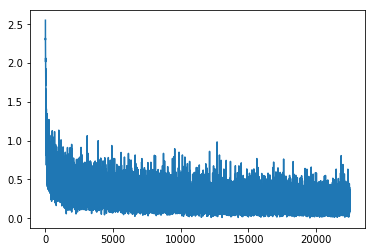

In [10]:
plt.plot(np.array(losses))
plt.show()

Collect the predictions for the test set.

In [11]:
# best weight values are saved in the checkpoint
with tf.Session() as sess:
    # restore the session that we used to train the model
    saver.restore(sess, './saved_model/cnn_fashion_mnist.ckpt')
    # get the predictions for all of the images in the testing dataset
    preds = sess.run(predictions, feed_dict={X: X_test})
    pred_val = tf.argmax(preds, 1).eval()

INFO:tensorflow:Restoring parameters from ./saved_model/cnn_fashion_mnist.ckpt


Display some of the images and their predicted values.

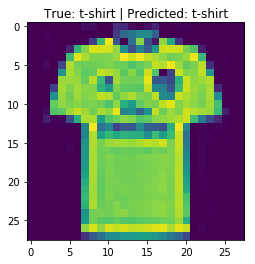

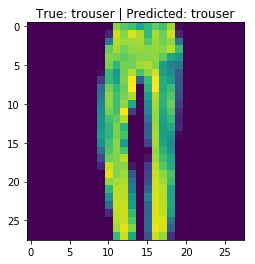

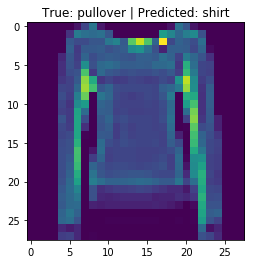

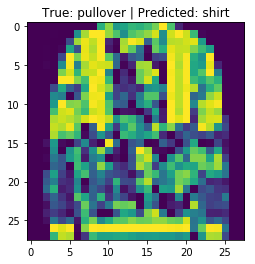

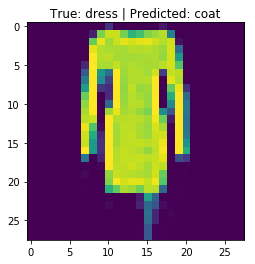

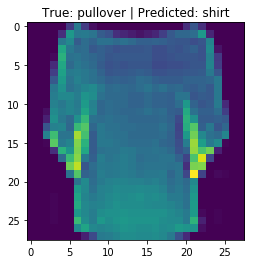

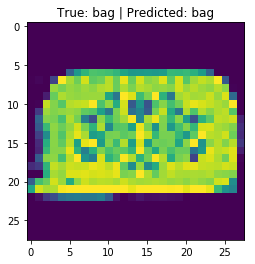

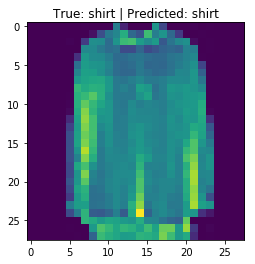

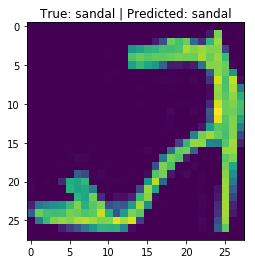

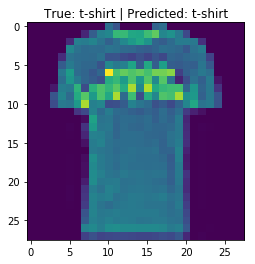

In [12]:
for j in range(10):
    plt.imshow(X_test[j].squeeze())
    plt.title('True: {} | Predicted: {}'.format(class_dict[np.argmax(y_test[j])],
                                                class_dict[pred_val[j]]))
    plt.show()